In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
plt.style.use('fivethirtyeight')

# Streak case

In [3]:
prod_streak = pd.read_excel('./Streak/Production_streak.xlsx')
inj_streak = pd.read_excel('./Streak/Injection_streak.xlsx')

In [29]:
streak = pd.concat([prod_streak,inj_streak],axis=1)

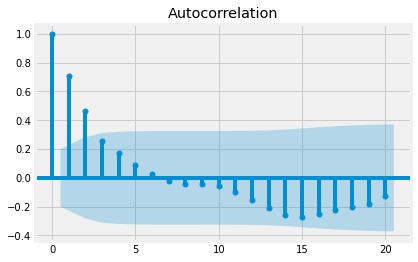

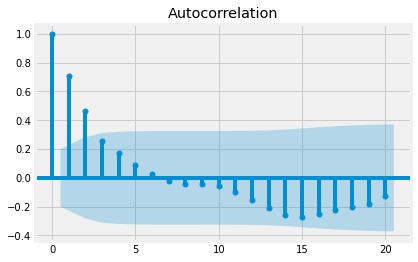

In [11]:
plot_acf(prod_streak.iloc[:,3].values)

it is unlikely moving average process it suggests that the time series can probably be modelled with an autoregressive process

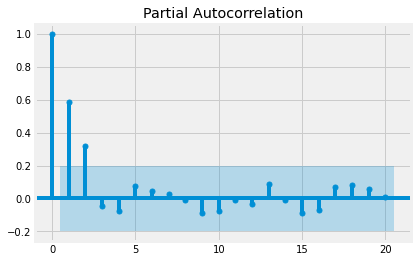

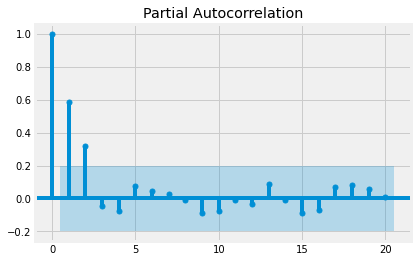

In [18]:
plot_pacf(prod_streak.iloc[:,4].values)


As you can see the coefficients are not significant after lag 3-4.

In [24]:
for i in range(1,5):
    rho, sigma = yule_walker(prod_streak.iloc[:,i].values, 2, method='mle')
    print(f'rho: {-rho}')
    print(f'sigma: {sigma}')




rho: [-0.28432591 -0.28419022]
sigma: 519.5624149188326
rho: [-0.41650391 -0.45761053]
sigma: 25.340056686239638
rho: [-0.76187769  0.07796994]
sigma: 47.863249848910606
rho: [-0.40211871 -0.30867487]
sigma: 379.77087548962595


In [26]:
for i in range(1,5):
    ad_fuller_result = adfuller(prod_streak.iloc[:,i].values)
    print(f'ADF Statistic: {ad_fuller_result[0]}')
    print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.784917373036931
p-value: 2.4459896512335096e-09
ADF Statistic: -0.8635302016722459
p-value: 0.799745149130192
ADF Statistic: -3.99600197448345
p-value: 0.001431591383151418
ADF Statistic: -3.528654692867171
p-value: 0.007280964555553066


Vector Autoregression (VAR) is a multivariate forecasting algorithm that is used when two or more time series influence each other
https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [28]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'

In [33]:
streak = streak.drop(columns=['Date'])

In [34]:
streak

,P1,P2,P3,P4,I1,I2,I3,I4,I5
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3030.190674,180.331818,180.511932,2409.921631,284.662415,1824.588013,278.588287,270.050903,769.642883
2,1034.125977,92.040901,254.523758,1092.091431,284.674286,1824.665039,278.600098,270.062286,769.675415
3,1242.952759,79.237770,357.866791,1284.484741,284.674286,1824.665039,278.600098,270.062286,769.675415
4,2894.078125,80.246880,343.474640,1714.793823,2040.237061,1067.610962,792.954712,259.661194,400.257812
...,...,...,...,...,...,...,...,...,...
91,3200.668945,261.394318,364.123749,3200.442383,2350.989990,1057.503052,1378.949951,1132.526001,1146.244995
92,3431.033691,251.648361,397.374817,3307.727783,2562.417969,1036.017944,1374.072998,1055.182983,1429.140015
93,3455.625732,220.472061,413.389954,3223.134277,2515.922119,1250.417969,1449.972046,799.789429,1246.973999
94,3679.903320,189.999924,424.907196,2884.804443,2709.281006,1382.046997,1184.909058,639.970215,1215.328979


In [35]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(streak, variables = streak.columns) 


,P1_x,P2_x,P3_x,P4_x,I1_x,I2_x,I3_x,I4_x,I5_x
P1_y,1.0000,0.0220,0.1492,0.0007,0.0000,0.0435,0.0766,0.1085,0.3971
P2_y,0.0066,1.0000,0.0019,0.0000,0.0148,0.0000,0.0051,0.0004,0.0008
P3_y,0.0000,0.0157,1.0000,0.0001,0.0001,0.0000,0.0007,0.0155,0.0001
P4_y,0.0002,0.0104,0.0109,1.0000,0.0011,0.0143,0.0014,0.1710,0.0383
I1_y,0.0024,0.0042,0.3402,0.0030,1.0000,0.2672,0.0744,0.1338,0.4914
I2_y,0.0000,0.0001,0.0559,0.0003,0.0000,1.0000,0.0065,0.0000,0.0240
I3_y,0.0003,0.0106,0.0023,0.0256,0.0056,0.0061,1.0000,0.1178,0.0028
I4_y,0.0012,0.0060,0.0000,0.0000,0.0027,0.0001,0.0007,1.0000,0.0001
I5_y,0.0000,0.5312,0.0482,0.0222,0.0000,0.0993,0.0018,0.2578,1.0000


In [36]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(streak)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
P1     ::  375.33    > 179.5199  =>   True
P2     ::  272.57    > 143.6691  =>   True
P3     ::  196.14    > 111.7797  =>   True
P4     ::  134.26    > 83.9383   =>   True
I1     ::  86.59     > 60.0627   =>   True
I2     ::  45.41     > 40.1749   =>   True
I3     ::  21.01     > 24.2761   =>   False
I4     ::  5.95      > 12.3212   =>   False
I5     ::  0.03      > 4.1296    =>   False


In [37]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [38]:
for name, column in streak.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "P1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.7849
 No. Lags Chosen       = 0
 Critical value 1%     = -3.501
 Critical value 5%     = -2.892
 Critical value 10%    = -2.583
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "P2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.8635
 No. Lags Chosen       = 7
 Critical value 1%     = -3.507
 Critical value 5%     = -2.895
 Critical value 10%    = -2.585
 => P-Value = 0.7997. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "P3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significan

In [49]:
p4 = streak.iloc[:,4:]

In [50]:
model = VAR(p4)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  53.99598116610289
BIC :  54.802468605555696
FPE :  2.8217741417643482e+23
HQIC:  54.321862598261006 

Lag Order = 2
AIC :  53.91361915028067
BIC :  55.40171716118333
FPE :  2.610516141806022e+23
HQIC:  54.51470183005908 

Lag Order = 3
AIC :  53.84706137551751
BIC :  56.02564158468161
FPE :  2.4716512041737484e+23
HQIC:  54.72670974448125 

Lag Order = 4
AIC :  53.65772563156507
BIC :  56.535853898849304
FPE :  2.0942584007932733e+23
HQIC:  54.8193625867486 

Lag Order = 5
AIC :  53.384920827906605
BIC :  56.97186298007354
FPE :  1.6607248379150693e+23
HQIC:  54.832028580188236 

Lag Order = 6
AIC :  53.54752883014562
BIC :  57.85275659571441
FPE :  2.0852583475928635e+23
HQIC:  55.28364973152213 

Lag Order = 7
AIC :  53.694678837077774
BIC :  58.72787598934502
FPE :  2.6654875773601772e+23
HQIC:  55.723416170124366 

Lag Order = 8
AIC :  53.76175786883151
BIC :  59.53282658437733
FPE :  3.2921269133943854e+23
HQIC:  56.086776590768636 

Lag Order = 9
AIC :  53.20